# Import Libraries

In [1]:
# Import built-in Python libs
from pathlib import Path
from typing import List
from tqdm import tqdm
import os
import sys
import heapq

# Import data science libs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Import deep learning libs
import pytorch_lightning as pl
import torchmetrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Import weights & bias
import wandb

# Import data preprocessing libs
from tokenizers import Tokenizer
from torch.utils.data import DataLoader

%matplotlib inline
os.environ["TOKENIZERS_PARALLELISM"] = "False"

In [2]:
utils_path = Path.cwd().parent / "utils"
sys.path.append(str(utils_path))
from custom_tokenizer import load_jieba_tokenizer, load_janome_tokenizer

# Job Selection

In [3]:
job = 0     # 0 - sentencepiece, 1 - language specific

job_name = ["transformer_sentencepiece_ch2jp", "transformer_language_specific_ch2jp"]

tokenizer_job = ["sentencepiece", "language_specific"]
ch_tokenizer_job = ["ch_tokenizer.json", "jieba_tokenizer.json"]
jp_tokenizer_job = ["jp_tokenizer.json", "janome_tokenizer.json"]
embedding_job = ["sentencepiece_embedding", "language_specific_embedding"]

In [4]:
method = 2
method_name = ["semantic", "phonetic", "meta", "concat"]

ch_embedding_method = [
    "ch_embedding.npy",
    "chp_embedding.npy",
    "ch_meta_embedding.npy",
    "ch_concat_embedding.npy",
]

jp_embedding_method = [
    "jp_embedding.npy",
    "jpp_embedding.npy",
    "jp_meta_embedding.npy",
    "jp_concat_embedding.npy",
]

# Config and WandB

In [5]:
config = {
    "enc_layers": 3,
    "dec_layers": 3,
    "enc_heads": 6,
    "dec_heads": 6,
    "enc_pf_dim": 512,
    "dec_pf_dim": 512,
    "enc_dropout": 0.1,
    "dec_dropout": 0.1,
    "hid_dim": (300 if method != 3 else 600),
    "lr": 5e-4,
    "batch_size": 64,
    "num_workers": 1,
    "precision": 32,
}

In [6]:
run = wandb.init(
    project="phonetic-translation",
    entity="windsuzu",
    group="experiments",
    job_type=job_name[job] + "-" + method_name[method],
    config=config,
    reinit=True,
)

wandb: Currently logged in as: windsuzu (use `wandb login --relogin` to force relogin)


# Download Datasets, Tokenizers, Embedding, DataModule

## Raw Data

In [7]:
train_data_art = run.use_artifact("sampled_train:latest")
train_data_dir = train_data_art.download()

dev_data_art = run.use_artifact("dev:latest")
dev_data_dir = dev_data_art.download()

test_data_art = run.use_artifact("test:latest")
test_data_dir = test_data_art.download()

data_dir = {
    "train": train_data_dir,
    "dev": dev_data_dir,
    "test": test_data_dir,
}

## Tokenizer

In [8]:
tokenizer_art = run.use_artifact(f"{tokenizer_job[job]}:latest")
tokenizer_dir = tokenizer_art.download()

src_tokenizer_dir = Path(tokenizer_dir) / ch_tokenizer_job[job]
trg_tokenizer_dir = Path(tokenizer_dir) / jp_tokenizer_job[job]

## Pretrained Embedding

In [9]:
embedding_art = run.use_artifact(f"{embedding_job[job]}:latest")
embedding_dir = embedding_art.download()

ch_embedding_dir = Path(embedding_dir) / ch_embedding_method[method]
jp_embedding_dir = Path(embedding_dir) / jp_embedding_method[method]

wandb: Downloading large artifact sentencepiece_embedding:latest, 732.42MB. 8 files... Done. 0:0:0


In [10]:
src_embedding = np.load(Path(ch_embedding_dir))
trg_embedding = np.load(Path(jp_embedding_dir))

src_embedding = torch.FloatTensor(src_embedding)
trg_embedding = torch.FloatTensor(trg_embedding)

In [11]:
print(src_embedding.shape)
print(trg_embedding.shape)

torch.Size([32000, 300])
torch.Size([32000, 300])


## DataModule

In [12]:
class SentencePieceDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data_dir,
        src_tokenizer_dir,
        trg_tokenizer_dir,
        batch_size=128,
        num_workers=8,
        pin_memory=True,
        job=0,
    ):
        super().__init__()
        self.data_dir = data_dir
        self.src_tokenizer_dir = src_tokenizer_dir
        self.trg_tokenizer_dir = trg_tokenizer_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory
        self.job = job

    def setup(self, stage=None):
        self.src_tokenizer = self._load_tokenizer(self.src_tokenizer_dir)
        self.trg_tokenizer = self._load_tokenizer(self.trg_tokenizer_dir)

        if stage == "fit":
            self.train_set = self._data_preprocess(self.data_dir["train"])
            self.val_set = self._data_preprocess(self.data_dir["dev"])

        if stage == "test":
            self.test_set = self._data_preprocess(self.data_dir["test"])

    def train_dataloader(self):
        return DataLoader(
            self.train_set,
            self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            collate_fn=self._data_batching_fn,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_set,
            self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            collate_fn=self._data_batching_fn,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_set,
            self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            collate_fn=self._data_batching_fn,
        )

    def _read_data_array(self, data_dir):
        with open(data_dir, encoding="utf8") as f:
            arr = f.readlines()
        return arr

    def _load_tokenizer(self, tokenizer_dir):
        if self.job == 0:
            return Tokenizer.from_file(str(tokenizer_dir))
        else:
            return (
                load_jieba_tokenizer(tokenizer_dir)
                if "jieba" in str(tokenizer_dir)
                else load_janome_tokenizer(tokenizer_dir)
            )

    def _data_preprocess(self, data_dir):
        src_txt = self._read_data_array(Path(data_dir) / "ch.txt")
        trg_txt = self._read_data_array(Path(data_dir) / "jp.txt")
        parallel_txt = np.array(list(zip(src_txt, trg_txt)))
        return parallel_txt

    def _data_batching_fn(self, data_batch):
        data_batch = np.array(data_batch)  # shape=(batch_size, 2=src+trg)

        src_batch = data_batch[:, 0]  # shape=(batch_size, )
        trg_batch = data_batch[:, 1]  # shape=(batch_size, )

        # src_batch=(batch_size, longest_sentence)
        # trg_batch=(batch_size, longest_sentence)
        src_batch = self.src_tokenizer.encode_batch(src_batch)
        trg_batch = self.trg_tokenizer.encode_batch(trg_batch)

        # We have to sort the batch by their non-padded lengths in descending order,
        # because the descending order can help in `nn.utils.rnn.pack_padded_sequence()`,
        # which it will help us ignoring the <pad> in training rnn.
        # https://meetonfriday.com/posts/4d6a906a
        src_batch, trg_batch = zip(
            *sorted(
                zip(src_batch, trg_batch),
                key=lambda x: sum(x[0].attention_mask),
                reverse=True,
            )
        )

        return src_batch, trg_batch


In [13]:
dm = SentencePieceDataModule(
    data_dir,
    src_tokenizer_dir,
    trg_tokenizer_dir,
    config["batch_size"],
    config["num_workers"],
    job=job
)

### Test DataModule

In [14]:
dm.setup("test")

In [15]:
input_dim = dm.src_tokenizer.get_vocab_size()
output_dim = dm.trg_tokenizer.get_vocab_size()
print(input_dim, output_dim)

src_pad_idx = dm.src_tokenizer.token_to_id("[PAD]")
print(src_pad_idx)

32000 32000
3


In [16]:
i = 0
for src, trg in dm.test_dataloader():
    print(len(src), src[i], src[i].tokens)
    print()
    print(len(trg), trg[i], trg[i].tokens)
    break

64 Encoding(num_tokens=103, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]) ['[BOS]', '_日本', '从', '世界', '各国', '进口', '酱', '油', '等的', '各种', '调', '料', '_,', '_但', '公', '知', '的是在', '制造', '过程中', '致癌性', '物质的', '氯', '丙', '醇', '类', '作为', '副', '产品', '生成', '_3', '_-', '_氯', '_-', '_1', '_,', '_2', '_-', '_丙', '二醇', '_(', '_3', '_-', '_M', 'CP', 'D', '_)', '_、', '_1', '_,', '_3', '_-', '_二氯', '_-', '_2', '_-', '_丙', '醇', '_(', '_1', '_,', '_3', '_-', '_D', 'CP', '_)', '_、', '_2', '_-', '_氯', '_-', '_1', '_,', '_3', '_-', '_丙', '二醇', '_(', '_2', '_-', '_M', 'CP', 'D', '_)', '_以及', '_2', '_,', '_3', '_-', '_二氯', '_-', '_1', '_丙', '醇', '_(', '_2', '_,', '_3', '_-', '_D', 'CP', '_)', '_。', '[EOS]']

64 Encoding(num_tokens=115, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]) ['[BOS]', '_日本', 'へ', 'は世界', '各', '国', 'から', '醤', '油', 'などの', '種々の', '調', '味', '料', 'が', '輸入', 'されているが', '_,', '_製造', '過程', '中で', '発癌', 

# Build Lightning Model

## Encoder

In [17]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, max_len=250):
        super().__init__()
        
        self.tok_embedding = nn.Embedding.from_pretrained(src_embedding)
        self.pos_embedding = nn.Embedding(max_len, hid_dim)
        
        self.layers = nn.ModuleList([
            EncoderLayer(hid_dim, n_heads, pf_dim, dropout) for _ in range(n_layers)
        ])
        
        self.dropout = nn.Dropout(dropout)
        
        self.register_buffer("scale", torch.sqrt(torch.FloatTensor([hid_dim])))

        
    def forward(self, src, src_mask):
        # src      = [batch_size, src_len]
        # src_mask = [batch_size, 1, 1, src_len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).type_as(src)
        # pos = [batch_size, src_len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        # src = [batch_size, src_len, hid_dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
        # src = [batch_size, src_len, hid_dim]
        
        return src

## Encoder Layer

In [18]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, src, src_mask):
        # src     = [batch_size, src_len, hid_dim]
        # src_mask = [batch_size, 1, 1, src_len]
        
        # self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        # dropout, residual connection, layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        # src = [batch_size, src_len, hid_dim]
        
        
        # positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        # dropout, residual connection, layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        # src = [batch_size, src_len, hid_dim]
        
        return src

## Attention

In [19]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.register_buffer("scale", torch.sqrt(torch.FloatTensor([hid_dim])))

        
    def forward(self, query, key, value, mask=None):

        # query = [batch_size, query_len, hid_dim]
        # key = [batch_size, key_len, hid_dim]
        # value = [batch_size, value_len, hid_dim]
        
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        # Q = [batch_size, query_len, hid_dim]
        # K = [batch_size, key_len, hid_dim]
        # V = [batch_size, value_len, hid_dim]
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        # Q = [batch_size, n_heads, query_len, head_dim]
        # K = [batch_size, n_heads, key_len, head_dim]
        # V = [batch_size, n_heads, value_len, head_dim]
        

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        # energy = [batch_size, n_heads, query_len, key_len]
        
        attention = torch.softmax(energy, dim = -1)
        # attention = [batch_size, n_heads, query_len, key_len]
        
        x = torch.matmul(self.dropout(attention), V)
        # x = [batch_size, n_heads, query_len, head_dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        # x = [batch_size, query_len, n_heads, head_dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        # x = [batch_size, query_len, hid_dim]
        
        x = self.fc_o(x)
        # x = [batch_size, query_len, hid_dim]
        
        return x, attention

## Position-wise Feedforward Layer

In [20]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x = [batch_size, seq_len, hid_dim]
        
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        # x = [batch_size, seq_len, pf_dim]
        
        
        x = self.fc_2(x)
        # x = [batch_size, seq_len, hid_dim]
        
        return x

## Decoder

In [21]:
class Decoder(nn.Module):
    def __init__(
        self, output_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, max_len=250
    ):
        super().__init__()

        self.tok_embedding = nn.Embedding.from_pretrained(trg_embedding)
        self.pos_embedding = nn.Embedding(max_len, hid_dim)

        self.layers = nn.ModuleList(
            [DecoderLayer(hid_dim, n_heads, pf_dim, dropout) for _ in range(n_layers)]
        )

        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
        self.register_buffer("scale", torch.sqrt(torch.FloatTensor([hid_dim])))
        
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        # trg = [batch_size, trg_len]
        # enc_src = [batch_size, src_len, hid_dim]
        # trg_mask = [batch_size, 1, trg_len, trg_len]
        # src_mask = [batch_size, 1, 1, src_len]
        
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).type_as(trg)
        # pos = [batch_size, trg_len]
        
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        # trg = [batch_size, trg_len, hid_dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        # trg = [batch_size, trg_len, hid_dim]
        # attention = [batch_size, n heads, trg_len, src_len]
        
        output = self.fc_out(trg)
        # output = [batch_size, trg_len, output_dim]
        
        return output, attention

## Decoder Layer

In [22]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    
    def forward(self, trg, enc_src, trg_mask, src_mask):
        # trg = [batch_size, trg_len, hid_dim]
        # enc_src = [batch_size, src_len, hid_dim]
        # trg_mask = [batch_size, 1, trg_len, trg_len]
        # src_mask = [batch_size, 1, 1, src_len]
        
        # self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        # dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
         
        # trg = [batch_size, trg_len, hid_dim]
        # ====================================
        
        # encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        
        # trg = [batch_size, trg_len, hid_dim]
        # ====================================
        
        
        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        # trg = [batch_size, trg_len, hid_dim]
        # ====================================
        
        # attention = [batch_size, n_heads, trg_len, src_len]
        
        return trg, attention

## Full Seq2Seq Model

In [23]:
class Seq2SeqModel(pl.LightningModule):
    def __init__(self, input_dim, output_dim, trg_tokenizer, config):
        super().__init__()
        self.trg_tokenizer = trg_tokenizer
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.encoder = Encoder(
            input_dim,
            config["hid_dim"],
            config["enc_layers"],
            config["enc_heads"],
            config["enc_pf_dim"],
            config["enc_dropout"],
        )

        self.decoder = Decoder(
            output_dim,
            config["hid_dim"],
            config["dec_layers"],
            config["dec_heads"],
            config["dec_pf_dim"],
            config["dec_dropout"],
        )

        self.lr = config["lr"]
        self.apply(self.initialize_weights)
    
    
    def initialize_weights(self, m):
        if hasattr(m, 'weight') and m.weight.dim() > 1:
            nn.init.xavier_uniform_(m.weight.data)
    
    
    # Training
    # Use only when training and validation
    def _forward(self, src, trg):
        # src = list of Encoding([ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
        # trg = list of Encoding([ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

        # src_batch = [batch_size, src_len]
        # src_mask  = [batch_size, 1, 1, src_len]
        src_batch = torch.tensor([e.ids for e in src], device=self.device)
        src_mask = torch.tensor([e.attention_mask for e in src], device=self.device).unsqueeze(1).unsqueeze(2)
        
        # trg_batch = [batch_size, trg_len-1]
        # trg_mask  = [batch_size, 1, trg_len-1, trg_len-1]
        trg_batch = torch.tensor([e.ids[:-1] for e in trg], device=self.device)
        trg_pad_mask = torch.tensor([e.attention_mask[:-1] for e in trg], device=self.device).unsqueeze(1).unsqueeze(2)
        
        trg_len = trg_batch.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        trg_mask = trg_pad_mask & trg_sub_mask
        
        # enc_src = [batch_size, src_len, hid_dim]
        enc_src = self.encoder(src_batch, src_mask)
        
        # output = [batch_size, trg_len, output_dim]
        # attention = [batch_size, n_heads, trg_len, src_len]
        output, attention = self.decoder(trg_batch, enc_src, trg_mask, src_mask)
        
        return output, attention


    def training_step(self, batch, batch_idx):
        # both are lists of encodings
        src, trg = batch
        
        y = torch.tensor([e.ids for e in trg], device=self.device)
        preds, _ = self._forward(src, trg)
        # y    = [batch_size, trg_len]
        # pred = [batch_size, trg_len-1, output_dim]
        
        output_dim = preds.shape[-1]
        
        # y    = [batch_size * (trg_len-1)]
        # pred = [batch_size * (trg_len-1), output_dim]
        y = y[:, 1:].contiguous().view(-1)
        preds = preds.contiguous().view(-1, output_dim)
        
        loss = F.cross_entropy(preds, y, ignore_index=self.trg_tokenizer.token_to_id("[PAD]"))
        self.log("train_loss", loss)

        perplexity = torch.exp(loss)
        self.log("train_ppl", perplexity)
        
        if self.global_step % 100 == 0:
            torch.cuda.empty_cache()
            
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        src, trg = batch
        y = torch.tensor([e.ids for e in trg], device=self.device)
        preds, _ = self._forward(src, trg)
        
        output_dim = preds.shape[-1]
        y = y[:, 1:].contiguous().view(-1)
        preds = preds.contiguous().view(-1, output_dim)
        
        loss = F.cross_entropy(preds, y, ignore_index=self.trg_tokenizer.token_to_id("[PAD]"))
        self.log("valid_loss", loss, sync_dist=True)
        
        perplexity = torch.exp(loss)
        self.log("valid_ppl", perplexity, sync_dist=True)
        
    
    # Inference
    # * Let you use the pl model as a pytorch model.
    # * 
    # * pl_model.eval()
    # * pl_model(X)
    # *
    def forward(self, src, max_len=100):
        # src_batch    = [batch_size, src_len]
        # src_mask     = [batch_size, 1, 1, src_len]
        # real_src_len = [batch_size] (src_len without <pad>)
        src_batch = torch.tensor([e.ids for e in src], device=self.device)
        src_mask = torch.tensor([e.attention_mask for e in src], device=self.device).unsqueeze(1).unsqueeze(2)
        batch_size = src_batch.shape[0]
        
        # first input to the decoder = [BOS] tokens
        # trg_batch = [batch_size, 1]
        trg_batch = torch.tensor([self.trg_tokenizer.token_to_id("[BOS]")], device=self.device).repeat(batch_size).unsqueeze(1)
        
        # enc_src = [batch_size, src_len, hid_dim]
        enc_srctrg_pad_idxoder(src_batch, src_mask)
        
        for _ in range(1, max_len):
            trg_pad_mask = (trg_batch != self.trg_tokenizer.token_to_id("[PAD]")).unsqueeze(1).unsqueeze(2)
            trg_sub_mask = torch.tril(torch.ones((trg_batch.shape[1], trg_batch.shape[1]), device = self.device)).bool()
            trg_mask = trg_pad_mask & trg_sub_mask
            # trg_mask = [batch_size, 1, trg_len, trg_len]
            
            # output = [batch_size, trg_len, output_dim]
            # attention = [batch_size, n_heads, trg_len, src_len]
            output, attention = self.decoder(trg_batch, enc_src, trg_mask, src_mask)
            pred = output.argmax(2)[:, -1].unsqueeze(1)
            
            trg_batch = torch.cat([trg_batch, pred], dim=1)
        
        real_src_len = torch.sum(src_mask, axis=3).view(-1)

        return trg_batch, attention, real_src_len
        
        
    def test_step(self, batch, batch_idx):
        src, trg = batch
        
        output, attn_matrix = self._forward(src, trg)
        preds = output.argmax(2)
        src_mask = torch.tensor([e.attention_mask for e in src], device=self.device)
        real_src_len = torch.sum(src_mask, axis=1).view(-1)
        
        # attn_matrix  = [batch_size, n_heads, trg_len, src_len]
        # preds        = [batch_size, trg_len]
        # real_src_len = [batch_size]
        
        # convert `preds` tensor to list of real sentences (tokens)
        # meaning to cut the sentence by [EOS] and remove the [PAD] tokens
        
        # eos_pos = dict(sentence_idx: first_pad_position)
        #
        # e.g., {0: 32, 2: 55} 
        # Meaning that we have 32 tokens (include [EOS]) in the first predicted sentence
        # and `max_len` tokens (no [EOS]) in the second predicted setence
        # and 55 tokens (include [EOS]) in the third predicted sentence
        eos_pos = dict(reversed((preds == self.trg_tokenizer.token_to_id("[EOS]")).nonzero().tolist()))
    
        pred_sentences, attn_matrices = [], []
        for idx, (sentence, attention, src_len) in enumerate(zip(preds, attn_matrix, real_src_len)):
            
            # sentence  = [trg_len_with_pad]
            #           = [real_trg_len]
            pred_sentences.append(sentence[:eos_pos.get(idx)+1 if eos_pos.get(idx) else None])
            
            # attention = [n_heads, trg_len_with_pad, src_len_with_pad]
            #           = [n_heads, real_trg_len, real_src_len]
            attn_matrices.append(attention[:, :eos_pos.get(idx)+1 if eos_pos.get(idx) else None, :src_len])
        
        # source sentences for displaying attention matrix 
        src = [[token for token in e.tokens if token != "[PAD]"] for e in src]
        
        # target sentences for calculating BLEU scores
        trg = [[token for token in e.tokens if token != "[PAD]"] for e in trg]
        
        return pred_sentences, attn_matrices, src, trg
        
    
    def test_epoch_end(self, test_outputs):
        outputs = []
        for (pred_sent_list, attn_list, src_list, trg_list) in test_outputs:
            for pred_sent, attn, src, trg in list(zip(pred_sent_list, attn_list, src_list, trg_list)):
                pred_sent = list(map(self.trg_tokenizer.id_to_token, pred_sent))
                outputs.append((pred_sent, attn, src, trg))
        
        # outputs = list of predictions of testsets, each has a tuple of (pred_sentence, attn_matrix, src_sentence, trg_sentence)
        # pred_sentence = [trg_len]
        # attn_matrix   = [n_heads, trg_len, src_len]
        # src_sentence  = [src_len]
        # trg_sentence  = [trg_len]
        self.test_outputs = outputs
    

    def configure_optimizers(self):
        return torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=self.lr)
    
    
    def optimizer_zero_grad(self, epoch, batch_idx, optimizer, optimizer_idx):
        optimizer.zero_grad(set_to_none=True)


In [24]:
class EmbeddingFineTuning(pl.callbacks.BaseFinetuning):
    def __init__(self, unfreeze_at_epoch=2):
        super().__init__()
        self._unfreeze_at_epoch = unfreeze_at_epoch

    def freeze_before_training(self, pl_module):
        # freeze any module you want
        self.freeze(pl_module.encoder.tok_embedding)
        self.freeze(pl_module.decoder.tok_embedding)

    def finetune_function(self, pl_module, current_epoch, optimizer, optimizer_idx):
        # When `current_epoch` is hit, embedding will start training.
        if current_epoch == self._unfreeze_at_epoch:
            self.unfreeze_and_add_param_group(
                modules=[
                    pl_module.encoder.tok_embedding,
                    pl_module.decoder.tok_embedding,
                ],
                optimizer=optimizer,
            )

In [25]:
embedding_finetune = EmbeddingFineTuning(unfreeze_at_epoch=1)

In [26]:
wandb_logger = pl.loggers.WandbLogger()

model = Seq2SeqModel(
    input_dim,
    output_dim,
    dm.trg_tokenizer,
    config,
)

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,889,872 trainable parameters


# Training

In [28]:
ckpt_dir = Path("checkpoints")

checkpoint = pl.callbacks.ModelCheckpoint(dirpath=ckpt_dir,  # path for saving checkpoints
                                          filename=f"{job_name[job]}-{method_name[method]}-" + "{epoch}-{valid_loss:.3f}",
                                          monitor="valid_loss",
                                          mode="min",
                                          save_weights_only=True,
                                          save_top_k=7,
                                         )

/home/windsuzu/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: Checkpoint directory checkpoints exists and is not empty.
  warnings.warn(*args, **kwargs)


In [29]:
trainer = pl.Trainer(
    fast_dev_run=False,
    logger=wandb_logger,
    gpus=1,
    max_epochs=10,
    gradient_clip_val=1,
    precision=config["precision"],
    callbacks=[checkpoint, embedding_finetune],
#     resume_from_checkpoint=ckpt_dir / "jp2ch-valid_loss=4.153-bleu=0.3916.ckpt",
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [30]:
trainer.fit(model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 11.7 M
1 | decoder | Decoder | 22.4 M
------------------------------------
14.9 M    Trainable params
19.2 M    Non-trainable params
34.1 M    Total params
136.359   Total estimated model params size (MB)
/home/windsuzu/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/windsuzu/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


1

# Testing (BLEU Scores)

In [46]:
model.load_state_dict(torch.load(ckpt_dir/"transformer_sentencepiece_ch2jp-meta-epoch=5-valid_loss=5.256.ckpt")["state_dict"])

<All keys matched successfully>

In [47]:
trainer.test(model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


[{}]

In [48]:
def calculate_corpus_bleu(preds: List[str], refs: List[List[str]], n_gram=4):
    # arg example:
    # preds: ["机器人行业在环境问题上的措施", "松下生产科技公司也以环境先进企业为目标"]
    # refs: [["机器人在环境上的改变", "對於机器人在环境上的措施"],  ["松下科技公司的首要目标是解决环境问题"]]
    preds = list(map(list, preds))
    refs = [[list(sen) for sen in ref] for ref in refs]
    return torchmetrics.functional.nlp.bleu_score(preds, refs, n_gram=n_gram)

In [49]:
preds = [dm.trg_tokenizer.decode(list(map(dm.trg_tokenizer.token_to_id, output[0]))) for output in model.test_outputs]
refs = [[dm.trg_tokenizer.decode(list(map(dm.trg_tokenizer.token_to_id, output[3])))] for output in model.test_outputs]

bleu_score = calculate_corpus_bleu(preds, refs, n_gram=4)
print(bleu_score)

tensor(0.2088)


In [50]:
wandb.log({"bleu_score": 26.44})
run.finish()

train_loss,1.94845
train_ppl,7.01779
epoch,9
trainer/global_step,7819
_runtime,3760
_timestamp,1620985369
_step,166
valid_loss,5.29874
valid_ppl,223.61479
bleu_score,26.44


train_loss,██▇▇▆▆▆▆▆▅▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▃▃▂▂▂▂▂▁▁▁▂▁▁▁▁
train_ppl,█▆▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,█▆▄▃▂▁▁▁▁▁
valid_ppl,█▄▂▂▁▁▁▁▁▁
bleu_score,▁


# Case Study and Attention Matrix

In [69]:
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK TC']
plt.rcParams['axes.unicode_minus'] = False

def sentence_bleu(pred_token, trg_token):
    trg  = dm.trg_tokenizer.decode(list(map(dm.trg_tokenizer.token_to_id, trg_token)))
    pred = dm.trg_tokenizer.decode(list(map(dm.trg_tokenizer.token_to_id, pred_token)))
    return calculate_corpus_bleu([trg], [[pred]])


def case_study(pred_token, src_token, trg_token, attn_matrix):
    src  = dm.src_tokenizer.decode(list(map(dm.src_tokenizer.token_to_id, src_token)))
    trg  = dm.trg_tokenizer.decode(list(map(dm.trg_tokenizer.token_to_id, trg_token)))
    pred = dm.trg_tokenizer.decode(list(map(dm.trg_tokenizer.token_to_id, pred_token)))
    bleu = calculate_corpus_bleu([trg], [[pred]])
    
    print(f"SOURCE: \n{src}\n {'-'*100}")
    print(f"TARGET: \n{trg}\n {'-'*100}")
    print(f"PREDICTION: \n{pred}\n {'-'*100}")
    print(f"BLEU SCORE: {bleu}")
    
    plt.figure(figsize=(30, 30))
    for i in range(6):
        plt.subplot(3, 2, i+1)
        ax = sns.heatmap(attn_matrix[i], xticklabels=src_token, yticklabels=pred_token)
        ax.xaxis.set_ticks_position('top')

In [72]:
scores = []

for i in tqdm(range(len(model.test_outputs))):
    bleu = sentence_bleu(
        model.test_outputs[i][0],
        model.test_outputs[i][3],
    )
    scores.append(bleu)

100%|██████████| 2107/2107 [00:07<00:00, 290.21it/s]


In [75]:
heapq.nlargest(50, range(len(scores)), np.array(scores).take)[10:20]

[1663, 688, 1396, 1531, 1975, 1788, 756, 1148, 191, 1596]

SOURCE: 
再者,关于HCI中的印象的重要性和有效性进行论述。

 ----------------------------------------------------------------------------------------------------
TARGET: 
さらに,HCIにおける印象の重要性と有効性について述べる.
 ----------------------------------------------------------------------------------------------------
PREDICTION: 
なお,HCIにおける印象の重要性と有効性について述べる.
 ----------------------------------------------------------------------------------------------------
BLEU SCORE: 0.8907171487808228


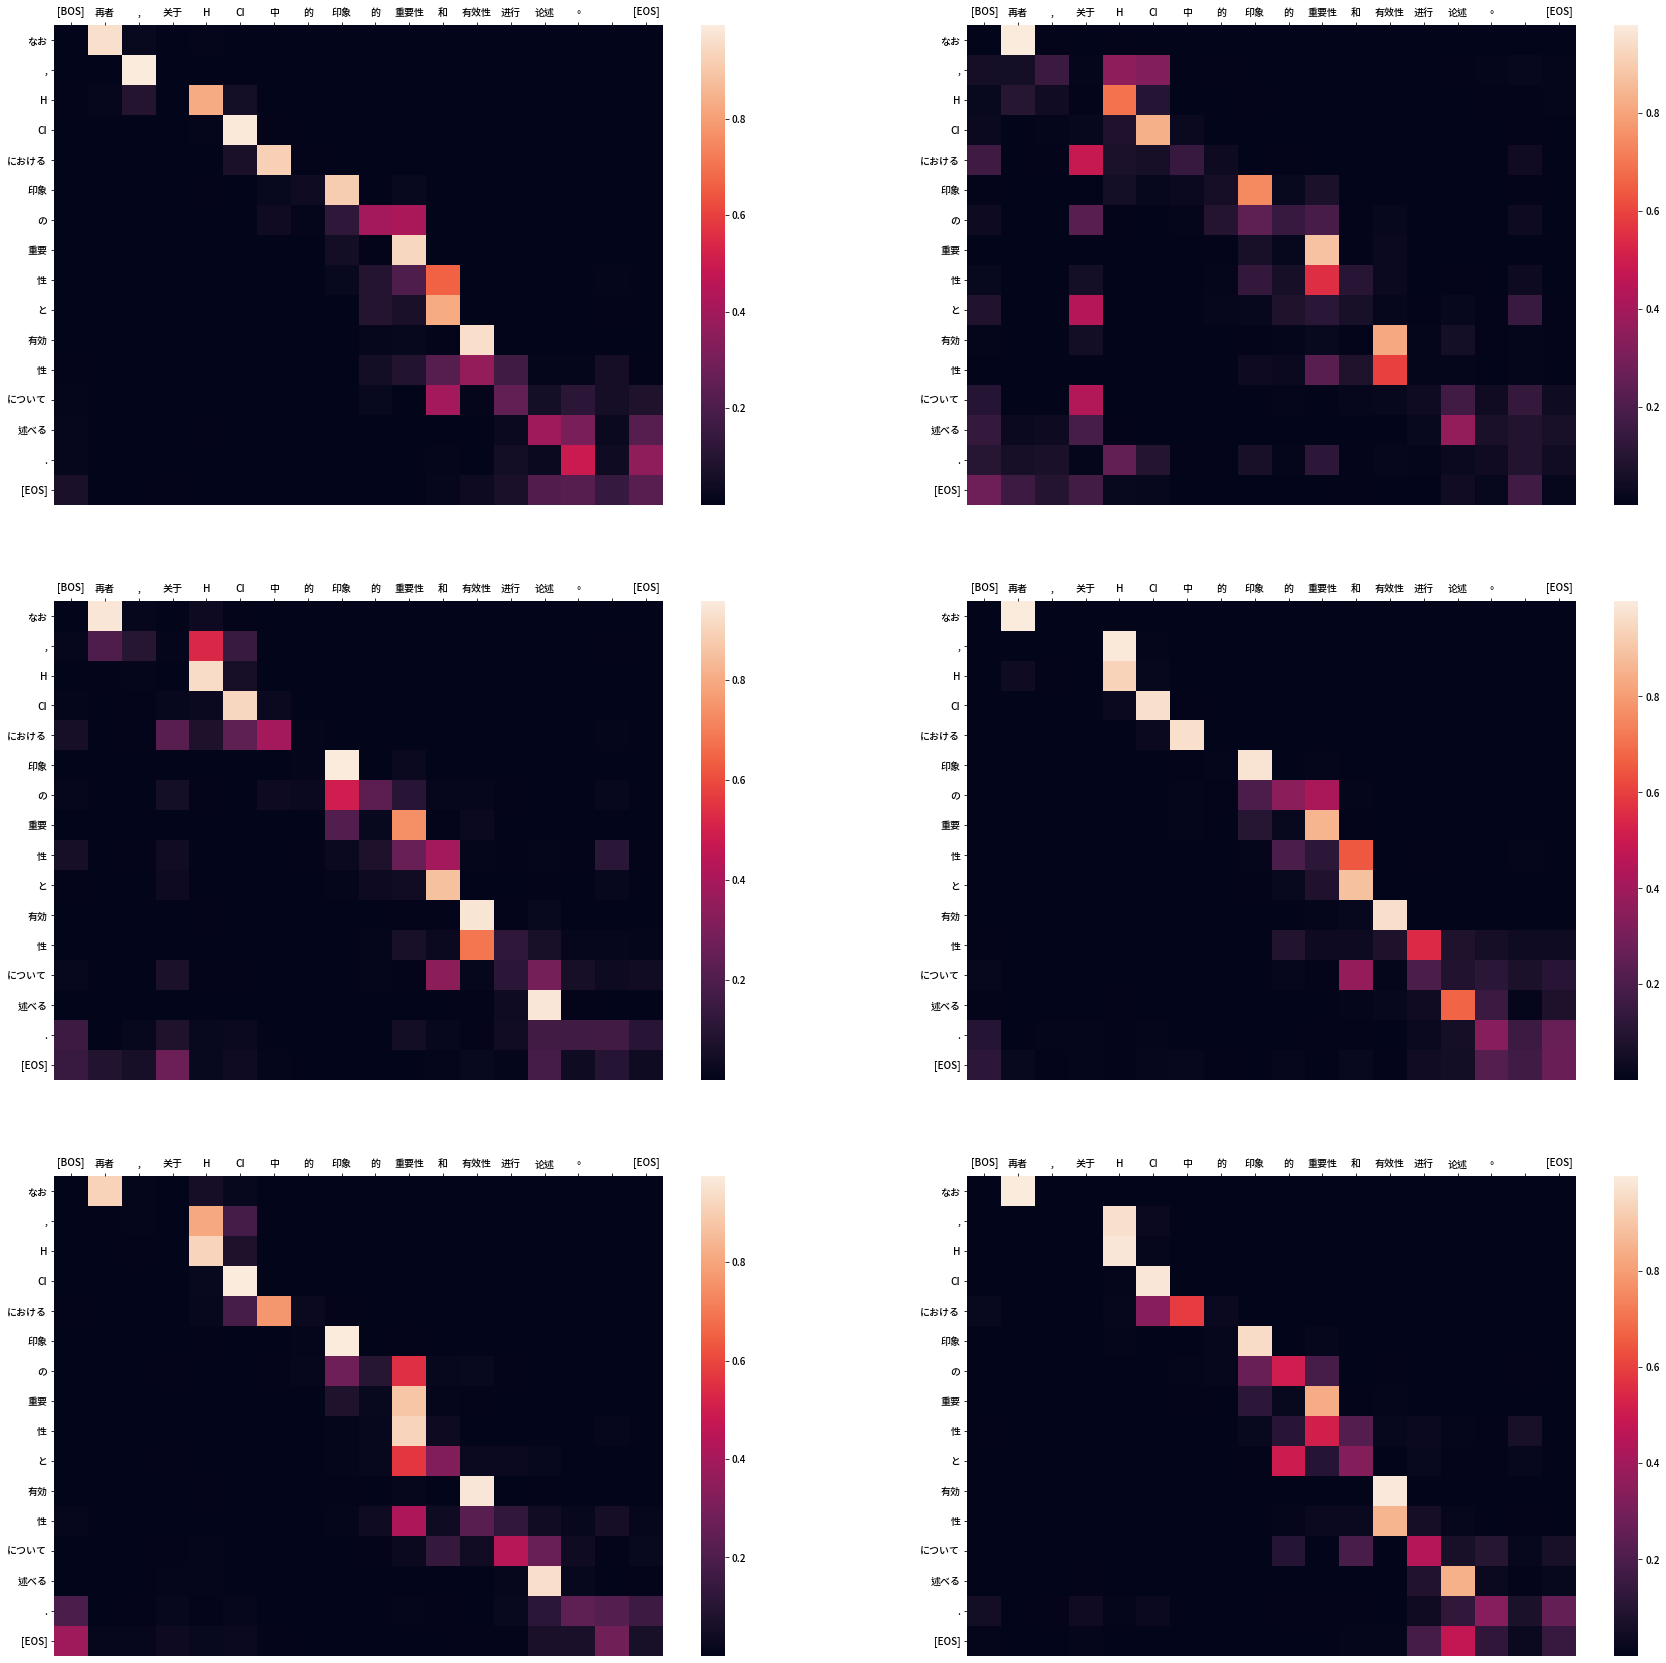

In [81]:
i=1975
case_study(model.test_outputs[i][0],
           model.test_outputs[i][2],
           model.test_outputs[i][3],
           model.test_outputs[i][1].cpu().numpy())